# RFM-анализ

## Описание задачи

Для нализа выбран датасет транзакций онлайн магазина, основной продукт которого - уникальная подарочная продукция на все случаи жизни. Многие покупатели являются оптовиками.

Цель - определить поведение покупателей, распределить похожих на группы и выбрать методики взаимодействий с ними.

## Обработка данных

In [2]:
#подключаемся к библиотекам
import pandas as pd
from datetime import datetime, timedelta
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

sns.set(rc={'figure.figsize':(10, 6)})

In [36]:
df = pd.read_csv('online_retail_listing.csv',  encoding="latin-1", sep=';', decimal=',')

Посмотрим на данные

In [37]:
print(f"Форма датафрейма: {df.shape}")
df.head()

Форма датафрейма: (1048575, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,1.12.2009 07:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,1.12.2009 07:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,1.12.2009 07:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,1.12.2009 07:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.12.2009 07:45,1.25,13085.0,United Kingdom


Для удобства я заменю поменяю правила написания имен столбцов и переведу формат столбца даты со строки на дату_время.

In [40]:
df = df.rename(columns={'Customer ID': 'customer_id', 'Invoice': 'invoice', 'StockCode' : 'stock_code', 'Description' : 'description', 
                   'Price' : 'price', 'Country' : 'country', 'Quantity' : 'quantity', 'InvoiceDate' : 'invoice_date'})

In [41]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'])

Посмотрим на временные рамки датафрейма.

In [42]:
print(f"Mах дата транзакции: {df.invoice_date.max()}")
print(f"Min дата транзакции: {df.invoice_date.min()}")

Mах дата транзакции: 2011-12-10 17:19:00
Min дата транзакции: 2009-01-12 07:45:00


Так как не целесообразно для rfm-анализа брать окно расчёта более, чем в один год, то я отфильтровую датасет, взяв данные только за 2010 год. К тому же только по нему данные являются полными (включают все сезоны).

In [44]:
df = df[df.invoice_date.dt.year == 2010]

In [45]:
print(f"Новая форма датафрейма: {df.shape}")

Новая форма датафрейма: (522714, 8)


У нас есть возвраты, в данных они характеризуются как записи с отрицательной или нулевой ценой или отрицательным количеством. Отсечем эти данные.

In [47]:
df = df.query('price > 0 and quantity > 0')

In [48]:
print(f"Новая форма датафрейма: {df.shape}")

Новая форма датафрейма: (509089, 8)


In [52]:
# Получаем общую сумму транзакции одной позиции, перемножая стоимость товара на момент покупки и количество купленного

df['sum'] = df.price * df.quantity

ТК мы анализируем поведение пользователя, данные необходимо агрегировать по ним.

Для расчёта параметра *recency*, возьмём последнюю дату покупки *last_date*, для *frequency* количество уникальных транзакций (тк в датасете одна транзакция разбита построчно по товарам) *cnt_purchases*, для *monetary* - общую сумму чека *total_bill*.

In [53]:
cust = df.groupby('customer_id' , as_index = False).agg(total_bill = ('sum', 'sum'), last_date = ('invoice_date', 'max'), cnt_purchases = ('invoice', 'nunique'))

In [55]:
print(f"Форма датафрейма: {cust.shape}")
cust.head()

Форма датафрейма: (4231, 4)


,customer_id,total_bill,last_date,cnt_purchases
0,12346.0,259.36,2010-06-28 13:53:00,6
1,12347.0,2035.11,2010-10-31 14:20:00,2
2,12348.0,1114.96,2010-12-16 19:09:00,2
3,12349.0,2671.14,2010-10-28 08:23:00,3
4,12351.0,300.93,2010-11-29 15:23:00,1


Для удобства дальнейшего расчёта *recency*, введём новый параметр - количество дней с прошлой покупки - day distance *(day_dist)*. Расчёт будет вестись относительно последующего дня после последней покупки в датафрейме.

In [56]:
end_date = cust.last_date.max() + timedelta(1)

cust['day_dist'] = cust.last_date.apply(lambda x: (end_date - x).days)

## Распределение по группам

Данные обработаны, теперь приступим к rfm-анализу.

Посмотрим на данные, построив их распределение по каждой из категорий (r/f/m) и взглянув на их квартили.

Гуппы будут нумероваться из правила: 3 - лучшая, 1 - худшая.

In [58]:
cust[['day_dist', 'cnt_purchases', 'total_bill']].describe()

,day_dist,cnt_purchases,total_bill
count,4231.000000,4231.000000,4231.000000
mean,100.245096,4.331127,2060.520682
std,92.046805,7.886804,8736.035987
min,1.000000,1.000000,3.750000
25%,30.000000,1.000000,311.255000
50%,67.000000,2.000000,729.480000
75%,150.000000,5.000000,1738.335000
max,356.000000,201.000000,335993.220000


### Recency

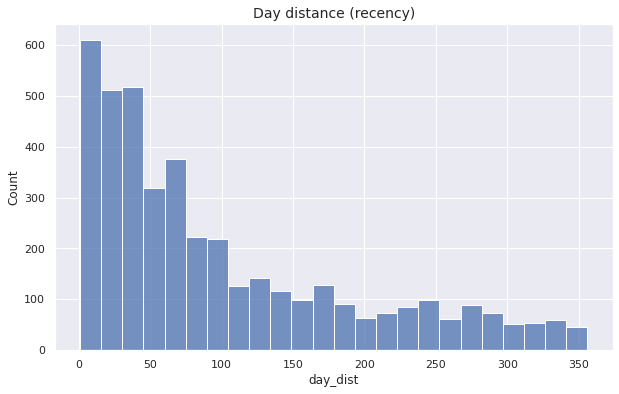

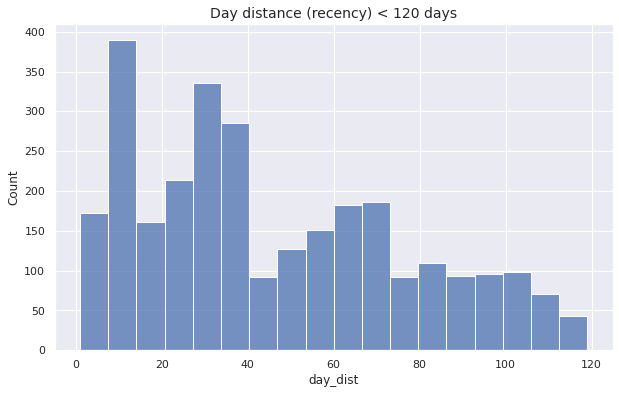

In [64]:
sns.histplot(cust.day_dist)
plt.title('Day distance (recency)', size = 14)
plt.show()
sns.histplot(cust[cust.day_dist < 120].day_dist)
plt.title('Day distance (recency) < 120 days', size = 14);

Тк магазин продаёт подарочную продукцию, то я возьму пробные границы из рыночных соображений: лояльный - покупал за последний месяц товар (еще хорошо помнит о нас), спящий - покупал до 4 месяцев (еще не забыл наш сервис), отток - покупки не было в последние 4 месяца - возможна потеря инетерса.

И визуально мы видим, что хвост имеет примерно стабильные значения после 100, и мы видим два пика до 40.

В случае recency группы я и ожидаю получить сбалансированные. Тк для подарочной проудкции раз в покупка раз в месяц уже лояльное поведние, но рамки широкие - кдиентов будет много. Свыше 4 месяцев - клиент уже может забыть о нас, для подарочной продукции также частое явление - разовая покупка - поэтому группа будет большой. И иногда покупающие между этими границами также буду распространены.

In [85]:
print("Объёмы покупателей в группах")
print(f"{cust.query('day_dist >= 120').customer_id.count()} - 1 категория")
print(f"{cust.query('day_dist < 120 and day_dist > 30').customer_id.count()} - 2 категория")
print(f"{cust.query('day_dist <= 30').customer_id.count()} - 3 категория")

print(f"\n{cust.query('day_dist >= 210').customer_id.count()} - свыше 7 мясецев")

Объёмы покупателей в группах
1331 - 1 категория
1779 - 2 категория
1121 - 3 категория

692 - свыше 7 мясецев


Посмотрев на объём этих групп, я закреплю пробные границы. Также отмечу, что много потерянных клиентов (половина 1 категории), которые уже вероятно не вернутся.

### Frequency

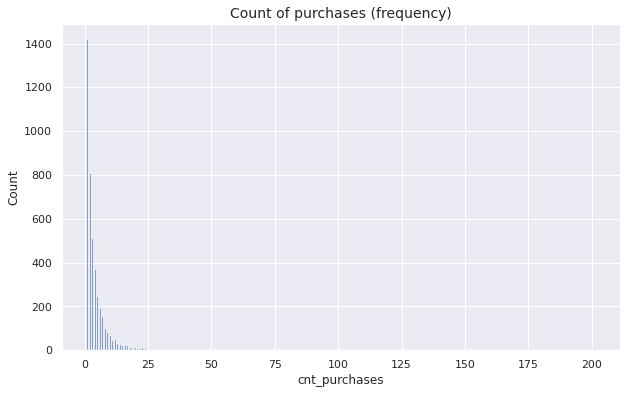

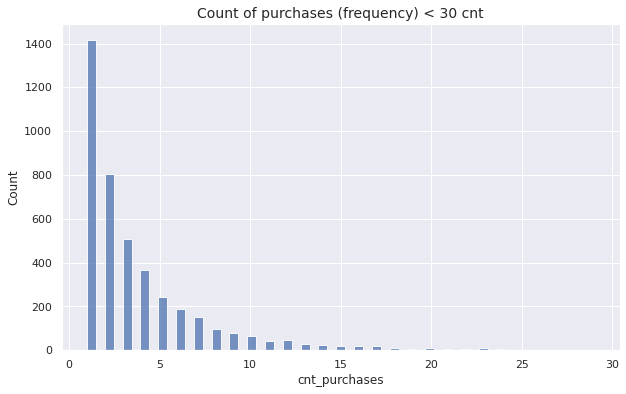

In [67]:
sns.histplot(cust.cnt_purchases)
plt.title('Count of purchases (frequency)', size = 14)
plt.show()
sns.histplot(cust[cust.cnt_purchases < 30].cnt_purchases)
plt.title('Count of purchases (frequency) < 30 cnt', size = 14);

В прошлом пункте о границах recency я говорила как: лояльный - покупал за последний месяц товар (еще хорошо помнит о нас), спящий - покупал до 4 месяцев (еще не забыл наш сервис), отток - покупки не было в последние 4 месяца - возможна потеря инетерса

Сохраняя эту логику для frequnce я возьму границы: лояльный - покупает 12 или более раз в год, спящий - от 4 до 12 (не включительно), отток - менее 4 раз в год.

Также в графиках наблюдается: длинный слабовыделенный хвост после 25 покупок в год, и пик разовой покупки.

In [86]:
print("Объёмы покупателей в группах")
print(f"{cust.query('cnt_purchases < 4').customer_id.count()} - 1 категория")
print(f"{cust.query('cnt_purchases >= 4 and cnt_purchases < 12').customer_id.count()} - 2 категория")
print(f"{cust.query('cnt_purchases >= 12').customer_id.count()} - 3 категория")

print(f"\n{cust.query('cnt_purchases <= 1').customer_id.count()} - разовая покупка из 1 категория")
print(f"{cust.query('cnt_purchases >= 30').customer_id.count()} - оптовики из 3 категории")

Объёмы покупателей в группах
2731 - 1 категория
1234 - 2 категория
266 - 3 категория

1418 - разовая покупка из 1 категория
45 - оптовики из 3 категории


In [87]:
print("Объёмы покупок в группах")
print(f"{cust.query('cnt_purchases < 4').cnt_purchases.sum()} покупок - 1 категория")
print(f"{cust.query('cnt_purchases >= 4 and cnt_purchases < 12').cnt_purchases.sum()} покупок - 2 категория")
print(f"{cust.query('cnt_purchases >= 12').cnt_purchases.sum()} покупок - 3 категория")

Объёмы покупок в группах
4550 покупок - 1 категория
7473 покупок - 2 категория
6302 покупок - 3 категория


Объём групп неравномерный, но этого следовало ожидать, тк треть всех покупателей совершили только одну покупку, но такие покупатели включают в себя и новых, и потерянных. Поэтому дисбаланс присуствует в frequency, но остуствует в recency, хотя логика рпзбияния та же.

И наблюдается резкое падение в объёме 3 категории. Приина - мало покупателей сохран яют свою лояльность в течении года.
Под условных оптовиков я выделила бы объёмы свыше 30, но для удобства академического анализа я буду считать их в дальнейшем частью 3 группы.

При подсчёте объема продаж каждой группы уже заметно, как высока для нас роль немногочисленной, но уверенной 3 группы.

### Monetary

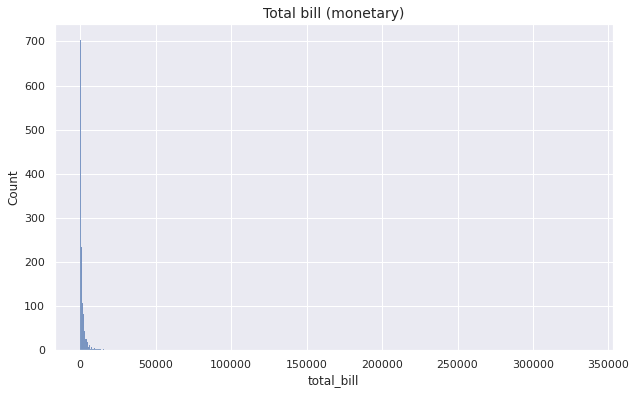

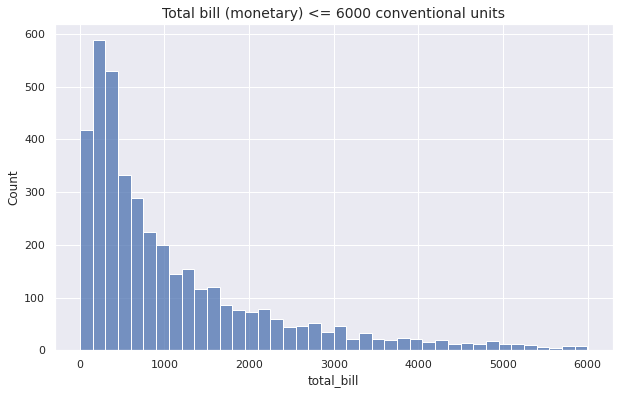

In [73]:
sns.histplot(cust.total_bill)
plt.title('Total bill (monetary)', size = 14)
plt.show()
sns.histplot(cust[cust.total_bill <= 6000].total_bill)
plt.title('Total bill (monetary) <= 6000 conventional units', size = 14);

Для распределния объёмов продаж пользователей характерен незаметный, но критически значимый для дохода хвост, начиная примерно с 6к. И пик в районе примерно 200 уе. Исходя из этого, я выбираю границы: свыше 3000 - лояльный покупатель, ниже 500 - редкий покупатель.

In [93]:
print("Объёмы покупателей в группах")
print(f"{cust.query('total_bill <= 500').customer_id.count()} - 1 категория")
print(f"{cust.query('total_bill > 500 and total_bill < 3000').customer_id.count()} - 2 категория")
print(f"{cust.query('total_bill >= 3000').customer_id.count()} - 3 категория")

print(f"{cust.query('total_bill >= 40000').customer_id.count()} - свыше 40к уе")

Объёмы покупателей в группах
1641 - 1 категория
2024 - 2 категория
566 - 3 категория
20 - свыше 40к уе


In [90]:
print("Объёмы продаж в группах")
print(f"{cust.query('total_bill <= 500').total_bill.sum()/1000:.0f}к уе - 1 категория")
print(f"{cust.query('total_bill > 500 and total_bill < 3000').total_bill.sum()/1000:.0f}к уе - 2 категория")
print(f"{cust.query('total_bill >= 3000').total_bill.sum()/1000:.0f}к уе - 3 категория")

Объёмы продаж в группах
421к уе - 1 категория
2633к уе - 2 категория
5664к уе - 3 категория


Для третьей группы характерно небольшое количество потребителей в 3 групппе, но именно они дают основной доход. Для нашего сервиса характерны оптовые закупки - с таких покупателей низкая маржа из-за оптовых цен, но благодаря количеству, мы как поставщики остаемся в очевидном плюсе.

1 категория даёт небольшие объёмы дохода, но у них есть потенциал стать любой из последующих категорий, как и войти в отток.

Во второй категории хорошие потребители, дают высокую маржу, их стоит удерживать и пытаться перевести в 3 категорию.

### RFM

Для всех распределний характерна положительная ассиметрия с длинным хвостом. Тк много разовых или маленьких покупателей, и емть покупатели (оптовики), которые тратят очень много у нас и приносят основную прибыль. Для таких датасетов (продажи) это характерное поведение. Поэтому стоит использовать медианные значения продаж для показа общей картины, тк среднее будет завышено благодаря выбросам (прибыль с оптовиков).

Исходя из анализа, определю функции дял группировки пользователей по показателей и применим их.

In [98]:
# Функция выбора сегмента для recency

def set_recency_score(recency):
    if recency <= 30:
        return 3
    if recency > 30 and recency < 120:
        return 2
    return 1

In [99]:
# Функция выбора сегмента для frequency

def set_frequency_score(frequency):
    if frequency >= 11:
        return 3
    if frequency < 11 and frequency > 4:
        return 2
    return 1

In [100]:
# Функция выбора сегмента для monetary

def set_monetary_score(monetary):
    if monetary >= 3000:
        return 3
    if monetary < 3000 and monetary > 500:
        return 2
    return 1

In [101]:
# Применим эти функции к нашему датасету

cust['recency'] = cust.day_dist.apply(set_recency_score)
cust['frequency'] = cust.cnt_purchases.apply(set_frequency_score)
cust['monetary'] = cust.total_bill.apply(set_monetary_score)

In [102]:
print(f"Форма датафрейма: {cust.shape}")
cust.head()

Форма датафрейма: (4231, 8)


,customer_id,total_bill,last_date,cnt_purchases,day_dist,recency,frequency,monetary
0,12346.0,259.36,2010-06-28 13:53:00,6,179,1,2,1
1,12347.0,2035.11,2010-10-31 14:20:00,2,54,2,1,2
2,12348.0,1114.96,2010-12-16 19:09:00,2,7,3,1,2
3,12349.0,2671.14,2010-10-28 08:23:00,3,57,2,1,2
4,12351.0,300.93,2010-11-29 15:23:00,1,25,3,1,1


In [105]:
# Соберем rfm сегмент для каждого пользователя

cust['rfm_segment'] = cust.recency.astype(str) + cust.frequency.astype(str) + cust.monetary.astype(str)

In [104]:
print(f"Форма датафрейма: {cust.shape}")
cust.head()

Форма датафрейма: (4231, 9)


,customer_id,total_bill,last_date,cnt_purchases,day_dist,recency,frequency,monetary,rfm_segment
0,12346.0,259.36,2010-06-28 13:53:00,6,179,1,2,1,121
1,12347.0,2035.11,2010-10-31 14:20:00,2,54,2,1,2,212
2,12348.0,1114.96,2010-12-16 19:09:00,2,7,3,1,2,312
3,12349.0,2671.14,2010-10-28 08:23:00,3,57,2,1,2,212
4,12351.0,300.93,2010-11-29 15:23:00,1,25,3,1,1,311


Для каждого пользователя определен тип поведения и выбрана соотвествующея этому категория.

## Анализ сегментации и выбор стратегий взаимодействия

Сегменты по поведению относительно r/f/m выбраны и пользователи по ним распределены. Теперь вглянем на полусенную картину, выделем для каждого сегмента свои правила взаимодействия, особенно уделим внимание главенствующим моделям поведения.

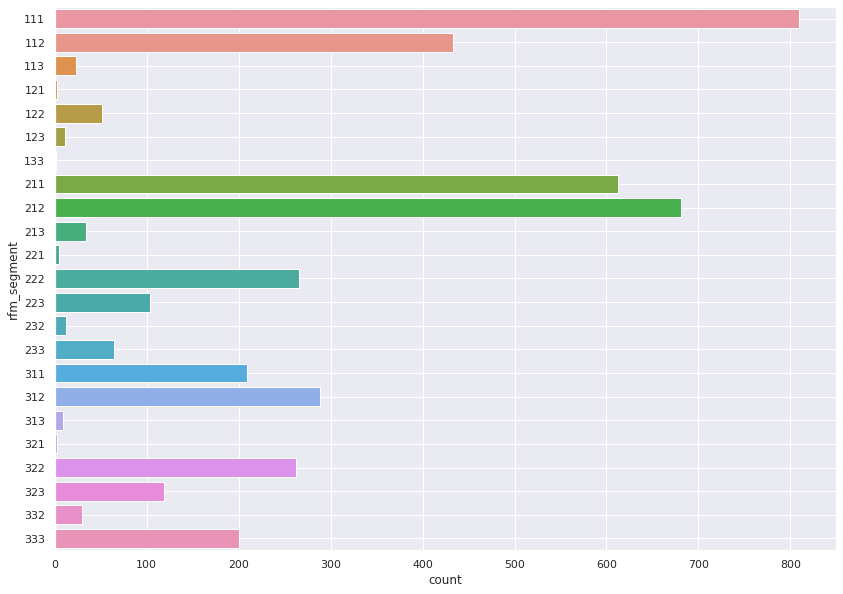

In [106]:
sns.set(rc={'figure.figsize':(14, 10)})
ax = sns.countplot(y = cust.sort_values(by=['rfm_segment']).rfm_segment)
plt.grid(True)    
sns.set(rc={'figure.figsize':(10, 6)})

В результате rfm-анализа можно выделить следующие группы:

* Преобладает *отток* пользователей **(группы 11x)**, что характерно для сервисов продаж, поэтому на работу с ними не рекомендуется выделять крупный бюджет. Минимальными ресурсами можно попробовать донести ценность продукта или предложить спец предложение. Если отклика нет, то концетрировать свое внимание на них в дальнейшем не стоит.

* **Клиенты 12х** совершали периодечески у нас покупки за год, но начали стремится к оттоку - можно провести обратную связь с выяснением причин, например, через опрос-рассылку.

* Почти нет *потерянных идеальных клиентов* (133), что говорит о хорошей работе с группой (333)

* **Клиенты 21х** - большая группа, имеют потенциал войти в отток ровно как и стать постоянной клиентурой. Эти клиенты были у нас недавно и ещё помнят нас как проудкт, поэтому с ними необходимо повзаимодействовать - провести рассылку, предложить бонус, например, за отзыв или в виде скидки.

* **Клиенты 22х** - также большая группа, которая может перейти в отток или в сегмент лояльных. Они чаще совершали покупки, чем предыдущая группа, поэтому их будет проще обернуть в лояльных. Таким клиентам подойдёт для напоминания о ценности нашего продукта персонализированная подборка товара в совокупности со спец предложением по этой подборке или скдидкой.

* **Клиенты 23х** - в нашем случае небольшая группа, но приносящая хороший доход. Есть угроза ухода в отток, поэтому обязательно провести с ними работу по удержанию: узнать, почему перестал покупать, что превлекает в продукте - по итогу диалогу предложить скидку. С особо прибыльными клиентами лучше вести диалог с помощью менеджера.

* **Клиенты 31х** - *новые клиенты*, основная цель - удержать. 

    Хорошо показать им заботу о клиенте - прислать информационную рассылку о купленном продукте, попросить от покупателя ценный фидбэк, скидку на следующий заказ с ограниченным сроком действия. Рассказать им выгоды нашей системы лояльности. 

    Необходимо выделить потенциальных VIPов и вести с ними отдельную кампанию, например, по привлечению друзей. 

* **Клиенты 32х & 332** - *лояльные клиенты*. Они уже оценили преимущества нашего сервиса и массовые рассылки могут их скорее отпугнуть. Целесообразно сообщать им о крупных расспродажах или осбо выгодных предложениях. Хороший ход - отправлять экспертные обзоры по новым товарам для нас / по активно покупаемым ими категориям / новым категориям для них, чтобы дать им импульс для покупки.

    Для маленького чека стоит предлагать подборки сопуствующего товара или скидки вида 3+1.
    Для почти идеальных пользователей 323 стоит поднять мотивацию к более частым покупкам, собрав их фидбэк, и на его основе попробовать поднять их активность.
    
* Для **клиентов хх1** - стоит провести работу по увеличению среднего чека.

* **Клиенты 333** - *идеальные* клиенты. Цель - удержать в этой категории как можно дольше, в идеале даже подняв их прибыльность. 

    Обычные скидки для таких клиентов не будут ключевым фактором заинтересованности. Они и так много и часто покупают. Стоит продемонстрировать их уникальность для нас, предложив VIP-услугу или VIP-товар, давать им уникальную информацию.
    
    Например, при оптовых закупках можно создать уникальное предложение по закупке нового дял них продукта, и провести отельно для них встречу с демонстрацией позитивных сторон предложения.

### Выводы

Основные выводы, которые можно выделить после нашего анализа продаж:

* Хорошая работа с идеальными 333 VIP-клиентами. Группа имеет выделяющийся объём пользователей. практически нет потерянных випов (133) и мало остывших к нам випам (223), которых еще и можно вернуть при работе с ними.

* Большой отток (11х) - сигнал о том, что мы слабо удерживаем новых клиентов или проводим неэффективные кампании по привлечению новых. Например, даем промокод при регистрации на первую покупку, а после не проводим с ним качественного удержания, отчего он теряет интерес.

* Много остывающих к нам клиентов (21х), которые нас еще помнят, но грозятся перейти в отток. Что опять же гвоорит о слабом удержании новичков. Большинство из них совершило покупки на средний чек, этим они показали заинтересованность в продукте, поэтому среди них хороший потенциал выйти в лояльных потребителей.

* Выделяющееся количество новичков (31х). То есть наш продукт популярен на рынке.